In [5]:
import exoplanet
import numpy as np
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle
import h5py
from tqdm import tqdm
from multiprocessing import Pool, cpu_count

print(exoplanet.__version__)

0.6.0


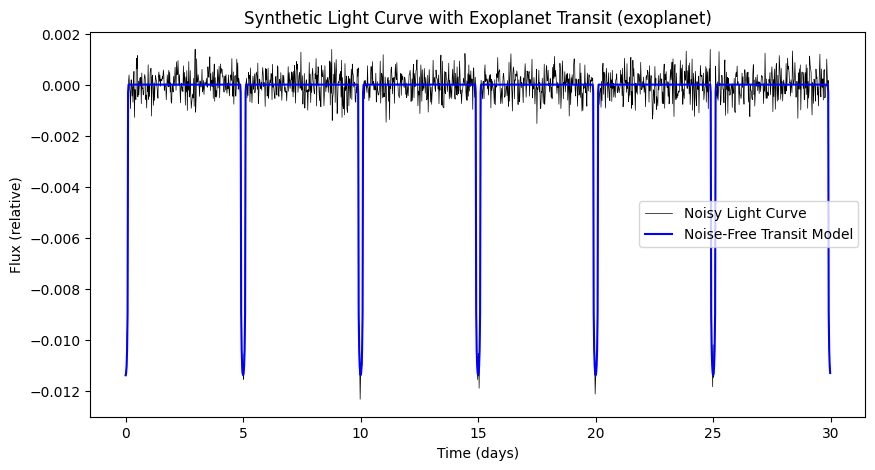

In [6]:
# Function to generate synthetic light curve with a transit using exoplanet
def generate_exoplanet_light_curve(period, rp, a, incl, total_time=30, cadence=30/1440, noise_level=0.001):
    # Create time array in days
    time = np.arange(0, total_time, cadence)
    
    # Define transit parameters for the light curve modelfrom astropy.timeseries import LombScargle

    t0 = total_time / 2  # midpoint of the transit in days
    
    # Create orbit model
    orbit = exoplanet.orbits.KeplerianOrbit(period=period, t0=t0, a=a, incl=incl)
    
    # Generate the limb-darkened transit model
    light_curve_model = exoplanet.LimbDarkLightCurve([0.3, 0.2]).get_light_curve(
        orbit=orbit, r=rp, t=time
    ).eval().flatten()
    
    # Add Gaussian noise
    flux_with_noise = light_curve_model + np.random.normal(0, noise_level, len(time))
    
    return time, flux_with_noise, light_curve_model  # Return model without noise for comparison

# Parameters for a sample exoplanet transit with an obvious dip
period = 5  # Shorter orbital period for a more frequent transit
rp = 0.1  # Larger planet radius in stellar radii for a deeper transit
a = 8  # Smaller semi-major axis to ensure transit visibility
incl = 89.5  # Nearly edge-on inclination
noise_level = 0.0005  # Lower noise level to highlight transit

# Generate synthetic light curve
time, flux_with_noise, combined_light_curve = generate_exoplanet_light_curve(period, rp, a, incl, noise_level=noise_level)

# Plot the generated light curve with and without noise
plt.figure(figsize=(10, 5))
plt.plot(time, flux_with_noise, label="Noisy Light Curve", color="black", lw=0.5)
plt.plot(time, combined_light_curve, label="Noise-Free Transit Model", color="blue", lw=1.5)
plt.xlabel("Time (days)")
plt.ylabel("Flux (relative)")
plt.title("Synthetic Light Curve with Exoplanet Transit (exoplanet)")
plt.legend()
plt.show()

In [7]:
def generate_multi_planet_light_curve(planets, star_radius=1.0, observation_noise=0.001, total_time=365, snr_threshold=5, u1 = 0.3, u2 = 0.2, cadence = 0.2):
    
    cadence = cadence#total_time/1440
    # Create time array in days
    time = np.arange(0, total_time, cadence)
    planet_light_curves = np.zeros_like(time)
    individual_light_curves = []  # Array to store each planet's light curve
    
    detected_count = 0
    star_radius_squared = star_radius ** 2  # Precompute star radius squared

    for planet in planets:
        period = planet['period']
        rp = planet['rp'] * star_radius  # Scale planet radius by star radius
        a = planet['a']
        incl = planet['incl']
        
        # Define transit midpoint
        t0 = planet['transit_midpoint']
        
        # Create orbit model
        orbit = exoplanet.orbits.KeplerianOrbit(period=period, t0=t0, a=a, incl=incl)
        
        # Generate the limb-darkened transit model
        light_curve_model = exoplanet.LimbDarkLightCurve([0.3, 0.2]).get_light_curve(
            orbit=orbit, r=rp, t=time
        ).eval().flatten()

        # Add to the combined light curve 
        planet_light_curves += light_curve_model
        

        
        # Estimate the transit depth
        transit_depth = (rp ** 2) / star_radius_squared
        
        # Calculate the SNR for each planet
        snr = transit_depth / observation_noise

        # Check if the planet is detectable based on SNR and the radius ratio condition
        if snr > snr_threshold:
            detected_count += 1
            # Store the individual light curve
            individual_light_curves.append(light_curve_model)
    
    # Add Gaussian noise based on the observation noise level
    flux_with_noise = planet_light_curves + np.random.normal(0, observation_noise, len(time))
    
    return time, flux_with_noise, planet_light_curves, detected_count, individual_light_curves


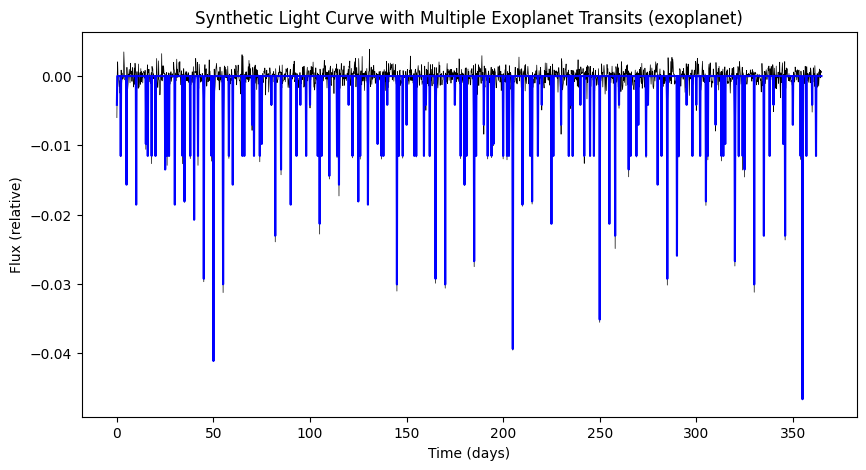

In [8]:
# Parameters for multiple planets
planets = [
    {'period': 5, 'rp': 0.06, 'a': 8, 'incl': np.pi / 2, 'transit_midpoint': 0},
    {'period': 8, 'rp': 0.1, 'a': 15, 'incl': np.pi / 2, 'transit_midpoint': 2},
    {'period': 11, 'rp': 0.1, 'a': 25, 'incl': np.pi / 2, 'transit_midpoint': 5},
#     {'period': 20, 'rp': 0.05, 'a': 30, 'incl': np.pi / 2, 'transit_midpoint': 10},
#     {'period': 30, 'rp': 0.07, 'a': 40, 'incl': np.pi / 2, 'transit_midpoint': 15},
#     {'period': 45, 'rp': 0.08, 'a': 50, 'incl': np.pi / 2, 'transit_midpoint': 20},
#     {'period': 60, 'rp': 0.09, 'a': 60, 'incl': np.pi / 2, 'transit_midpoint': 25},
#     {'period': 75, 'rp': 0.1, 'a': 70, 'incl': np.pi / 2, 'transit_midpoint': 30},
#     {'period': 90, 'rp': 0.11, 'a': 80, 'incl': np.pi / 2, 'transit_midpoint': 35},
#     {'period': 105, 'rp': 0.12, 'a': 90, 'incl': np.pi / 2, 'transit_midpoint': 40},
#     {'period': 120, 'rp': 0.13, 'a': 100, 'incl': np.pi / 2,   'transit_midpoint': 45},
#     {'period': 135, 'rp': 0.14, 'a': 110, 'incl': np.pi / 2, 'transit_midpoint': 50},
#     {'period': 150, 'rp': 0.15, 'a': 120, 'incl': np.pi / 2, 'transit_midpoint': 55},
# ]

# Define star radius and observation noise level
star_radius = 1.0  # Radius of the star (solar radii)
observation_noise = 0.001  # Observation noise (standard deviation)

# Generate synthetic light curve for multiple planets
time, flux_with_noise, combined_light_curve, detected_count, individual_light_curves = generate_multi_planet_light_curve(
    planets, star_radius=star_radius, observation_noise=observation_noise, snr_threshold=5
)
import h5py

# Plot the generated light curve with and without noise
plt.figure(figsize=(10, 5))
plt.plot(time, flux_with_noise, label="Noisy Light Curve", color="black", lw=0.5)
plt.plot(time, combined_light_curve, label="Noise-Free Transit Model", color="blue", lw=1.5)
plt.xlabel("Time (days)")
plt.ylabel("Flux (relative)")
plt.title("Synthetic Light Curve with Multiple Exoplanet Transits (exoplanet)")
plt.show()

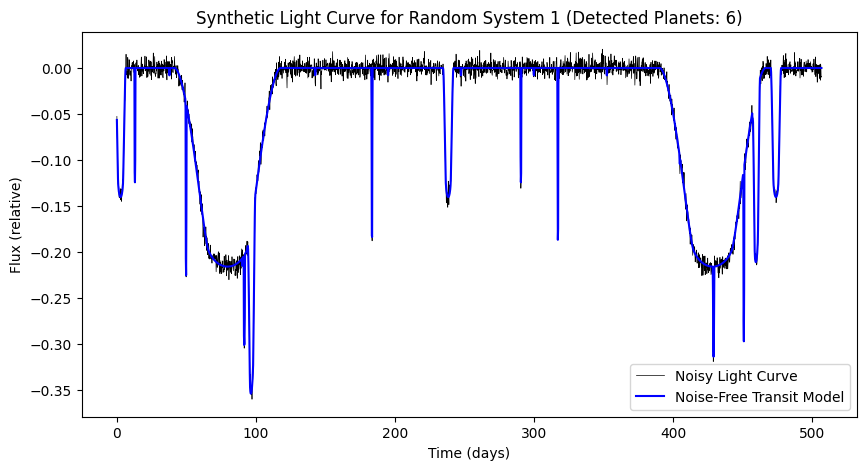

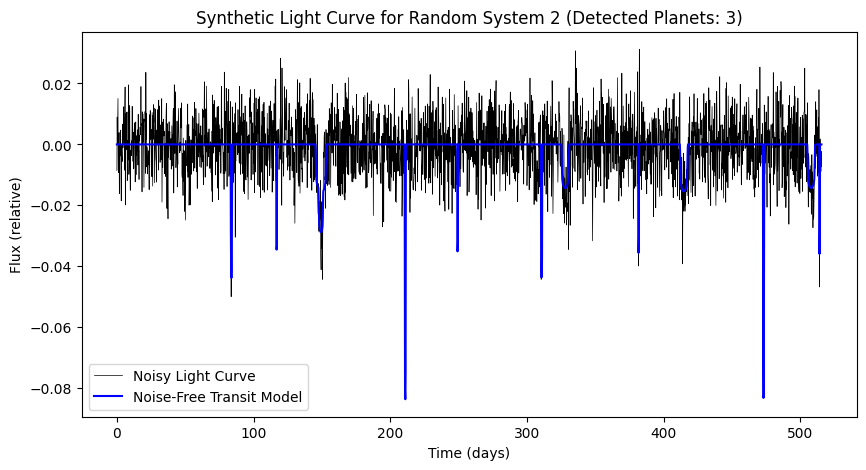

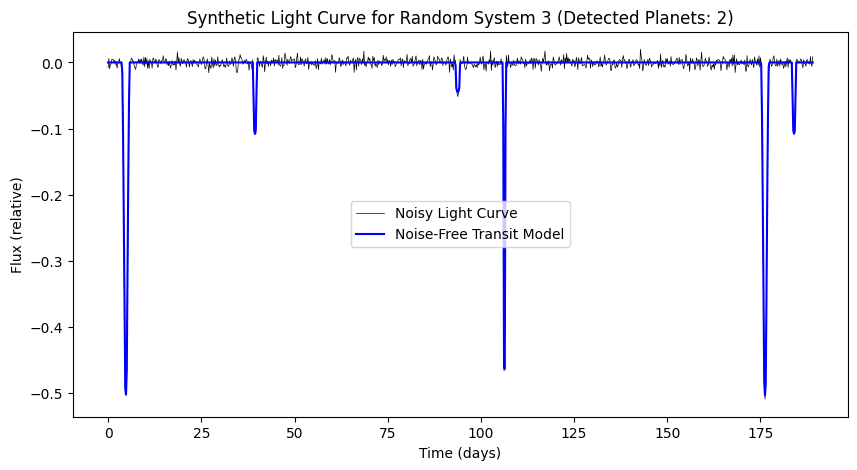

In [10]:
# Function to generate random planet systems
def generate_random_planet_systems(num_systems, max_planets_per_system):
    systems = []
    for _ in range(num_systems):        
        num_planets = np.random.randint(1, max_planets_per_system + 1)
        planets = []

        total_time= np.random.uniform(40, 720)  # Random total time between 0 and 720 days

        for _ in range(num_planets):
            period = np.random.uniform(1, 365)  # Random period between 1 and 365 days
            rp = np.random.uniform(0.05, 0.5)  # Random planet radius ratio between 0.01 and 0.2
            a = np.random.uniform(1, 150)  # Random semi-major axis
            incl = np.pi/2# np.random.uniform(0, np.pi)  # Random inclination
            transit_midpoint = np.random.uniform(0, total_time)  # Random transit midpoint between 0 and 365 days
            planets.append({'period': period, 'rp': rp, 'a': a, 'incl': incl, 'transit_midpoint': transit_midpoint})


        u1 = np.random.uniform(0.1, 0.5)
        u2 = np.random.uniform(0.1, 0.5)
        star_radius = np.random.uniform(0.5, 2.0)  # Random star radius between 0.5 and 2.0
        observation_noise = np.random.uniform(0.001, 0.01)  # Random observation noise between 0.0001 and 0.01
        systems.append({'planets': planets, 'star_radius': star_radius, 'observation_noise': observation_noise,'total_time':total_time,'u1':u1,'u2':u2})
    return systems


# Parameters
num_systems = 3
max_planets_per_system = 8
snr_threshold = 5

# Generate random planet systems
random_systems = generate_random_planet_systems(num_systems, max_planets_per_system)

# Store results in a structured array
data_type = [
    ('time', 'O'), 
    ('flux_with_noise', 'O'), 
    ('combined_light_curve', 'O'), 
    ('detected_count', 'i4'), 
    ('individual_light_curves', 'O'), 
    ('total_time', 'f8'), 
    ('star_radius', 'f8'),
    ('observation_noise', 'f8'),
    ('u1', 'f8'),
    ('u2', 'f8'),
    ('planets', 'O')
]

results = np.empty(num_systems, dtype=data_type)

# Generate transit curves for each random system
for i, system in enumerate(random_systems):
    time, flux_with_noise, combined_light_curve, detected_count, individual_light_curves = generate_multi_planet_light_curve(
        system['planets'], total_time=system['total_time'], star_radius=system['star_radius'], observation_noise=system['observation_noise'], snr_threshold=snr_threshold, u1=system['u1'], u2=system['u2']
    )        

    results[i] = (time, flux_with_noise, combined_light_curve, detected_count, individual_light_curves, system['total_time'], system['star_radius'], system['observation_noise'], system['u1'], system['u2'], system['planets'])

# Plot the first 3 generated light curves
for i in range(3):
    plt.figure(figsize=(10, 5))
    plt.plot(results[i]['time'], results[i]['flux_with_noise'], label="Noisy Light Curve", color="black", lw=0.5)
    plt.plot(results[i]['time'], results[i]['combined_light_curve'], label="Noise-Free Transit Model", color="blue", lw=1.5)
    plt.xlabel("Time (days)")
    plt.ylabel("Flux (relative)")
    plt.title(f"Synthetic Light Curve for Random System {i+1} (Detected Planets: {results[i]['detected_count']})")
    plt.legend()
    plt.show() 
        


In [ ]:
# Parameters
num_systems = 12
max_planets_per_system = 8
snr_threshold = 5
num_iterations = 1200

# Store results in a structured array
data_type = [
    ('time', 'O'), 
    ('flux_with_noise', 'O'), 
    ('combined_light_curve', 'O'), 
    ('detected_count', 'i4'), 
    ('individual_light_curves', 'O'), 
    ('total_time', 'f8'), 
    ('star_radius', 'f8'),
    ('observation_noise', 'f8'),
    ('u1', 'f8'),
    ('u2', 'f8'),
    ('planets', 'O')
]



# Function to generate and process a single system
def process_system(system):
    time, flux_with_noise, combined_light_curve, detected_count, individual_light_curves = generate_multi_planet_light_curve(
        system['planets'], total_time=system['total_time'], star_radius=system['star_radius'], observation_noise=system['observation_noise'], snr_threshold=snr_threshold, u1=system['u1'], u2=system['u2'], cadence=0.05
    )
    return (time, flux_with_noise, combined_light_curve, detected_count, individual_light_curves, system['total_time'], system['star_radius'], system['observation_noise'], system['u1'], system['u2'], system['planets'])

# Prepare HDF5 file
with h5py.File('planet_systems.hdf5', 'w') as hdf5_file:
    for iteration in tqdm(range(num_iterations), desc="Generating planet systems"):
        # Generate random planet systems
        max_planets_per_system = np.random.randint(1, 10)
        random_systems = generate_random_planet_systems(num_systems, max_planets_per_system)

        # Use multiprocessing to process systems in parallel
        with Pool(cpu_count()) as pool:
            results = pool.map(process_system, random_systems)

        # Save results to HDF5 file
        group = hdf5_file.create_group(f'iteration_{iteration}')
        for i, result in enumerate(results):
            system_group = group.create_group(f'system_{i}')
            system_group.create_dataset('time', data=result[0])
            system_group.create_dataset('flux_with_noise', data=result[1])
            system_group.create_dataset('combined_light_curve', data=result[2])
            system_group.create_dataset('detected_count', data=result[3])
            system_group.create_dataset('individual_light_curves', data=result[4])
            system_group.create_dataset('total_time', data=result[5])
            system_group.create_dataset('star_radius', data=result[6])
            system_group.create_dataset('observation_noise', data=result[7])
            system_group.create_dataset('u1', data=result[8])
            system_group.create_dataset('u2', data=result[9])
            
            planets_group = system_group.create_group('planets')
            for j, planet in enumerate(result[10]):
                planet_group = planets_group.create_group(f'planet_{j}')
                for key, value in planet.items():
                    planet_group.create_dataset(key, data=value)

print("HDF5 file created successfully.")

Generating planet systems:   2%|▏         | 20/1200 [00:50<47:32,  2.42s/it]  